In [41]:
import numpy as np
import tensorflow as tf
from datasets import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import h5py

In [42]:
train_low , train_high , test_low , test_high = load_dataset()

100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [00:03<00:00, 49.00it/s]


(256, 256, 3)


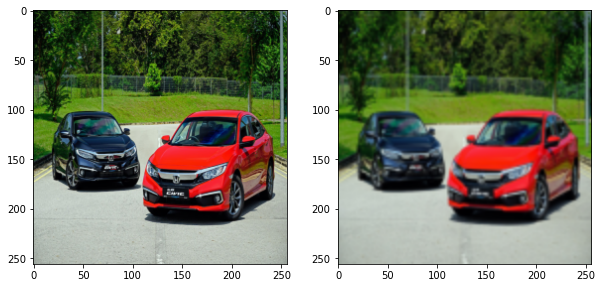

In [43]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(train_high[0])
plt.subplot(1,2,2)
plt.imshow(train_low[0])
print(train_high[0].shape)

In [44]:
def reshape_image(data):
    image = np.reshape(data,(len(data),256,256,3))
    return image

In [107]:
train_low = train_low[:90]
train_high = train_high[:90]
test_low = test_low[:90]
test_high = test_high[:90]

In [108]:
train_low = reshape_image(train_low)
train_high = reshape_image(train_high)
test_low = reshape_image(test_low)
test_high = reshape_image(test_high)


In [109]:
print("Training set of low resolution images: ",train_low.shape)
print("Training set of high resolution images: ",train_high.shape)
print("Testing set of low resolution images: ",test_low.shape)
print("Testing set of high resolution images: ",test_high.shape)

Training set of low resolution images:  (90, 256, 256, 3)
Training set of high resolution images:  (90, 256, 256, 3)
Testing set of low resolution images:  (90, 256, 256, 3)
Testing set of high resolution images:  (90, 256, 256, 3)


In [110]:
def down_sampling(filters,kernel_size,batch_norm=True):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(filters,kernel_size,padding='same',strides=2))
    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    return model

In [111]:
def up_sampling(filters,kernel_size,dropout=False):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2DTranspose(filters,kernel_size,padding='same',strides=2))
    if dropout:
        model.dropout(0.2)
    model.add(tf.keras.layers.ReLU())
    return model

In [112]:
def low_high(input_shape):
    X_input = tf.keras.layers.Input(input_shape)
    #downsampling
    X4 = down_sampling(128,(3,3),False)(X_input)
    X3 = down_sampling(128,(3,3),False)(X4)
    X2 = down_sampling(256,(3,3),True)(X3)
    X1 = down_sampling(512,(3,3),True)(X2)
    
    X = down_sampling(512,(3,3),True)(X1)
    #upsampling
    X = up_sampling(512,(3,3),False)(X)
    X = tf.keras.layers.concatenate([X,X1])
    X = up_sampling(256,(3,3),False)(X)
    X = tf.keras.layers.concatenate([X,X2])
    X = up_sampling(128,(3,3),False)(X)
    X = tf.keras.layers.concatenate([X,X3])
    X = up_sampling(128,(3,3),False)(X)
    X = tf.keras.layers.concatenate([X,X4])
    X = up_sampling(3,(3,3),False)(X)
    X = tf.keras.layers.concatenate([X,X_input])
    X = tf.keras.layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(X)
    
    return tf.keras.Model(inputs=X_input , outputs=X)

In [113]:
model = low_high(train_low.shape[1:])

In [114]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_52 (Sequential)      (None, 128, 128, 128 3584        input_7[0][0]                    
__________________________________________________________________________________________________
sequential_53 (Sequential)      (None, 64, 64, 128)  147584      sequential_52[0][0]              
__________________________________________________________________________________________________
sequential_54 (Sequential)      (None, 32, 32, 256)  296192      sequential_53[0][0]              
______________________________________________________________________________________

In [123]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , loss=tf.keras.losses.MeanAbsoluteError() ,
             metrics = ['accuracy'])

In [124]:
model.fit(train_low,train_high,epochs=7,batch_size=1)

Epoch 1/7
90/90 [==============================] - 18s 202ms/step - loss: 0.0327 - accuracy: 0.7736
Epoch 2/7
90/90 [==============================] - 19s 216ms/step - loss: 0.0304 - accuracy: 0.7895
Epoch 3/7
90/90 [==============================] - 20s 225ms/step - loss: 0.0276 - accuracy: 0.8019
Epoch 4/7
90/90 [==============================] - 20s 226ms/step - loss: 0.0265 - accuracy: 0.7846
Epoch 5/7
90/90 [==============================] - 20s 226ms/step - loss: 0.0250 - accuracy: 0.8136
Epoch 6/7
90/90 [==============================] - 21s 230ms/step - loss: 0.0278 - accuracy: 0.7768
Epoch 7/7
90/90 [==============================] - 21s 230ms/step - loss: 0.0290 - accuracy: 0.8181


In [126]:
pred = model.predict(test_low[2].reshape(1,256,256,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


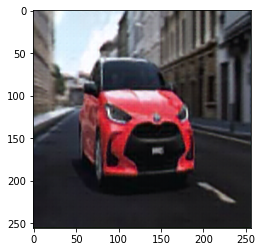

In [127]:

plt.imshow(pred.reshape(256,256,3))

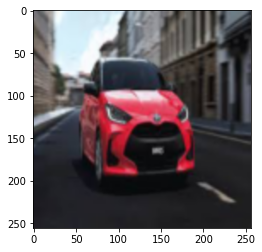

In [128]:
#plt.figure(figsize=(10,10))
plt.imshow(test_low[2].reshape(256,256,3))

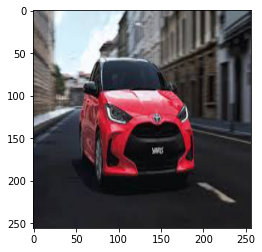

In [129]:

plt.imshow(test_high[2].reshape(256,256,3))

In [130]:
loss,accuracy = model.evaluate(test_low , test_high)

3/3 [==============================] - 3s 1s/step - loss: 0.0254 - accuracy: 0.8382
